# 🤖 Modelo XGBoost - Previsão de Vendas

Este notebook implementa o modelo de previsão de vendas utilizando **XGBoost (Extreme Gradient Boosting)**.

## 🎯 Objetivos
- Treinar modelo XGBoost para prever quantidade semanal de vendas
- Otimizar hiperparâmetros usando Optuna
- Avaliar performance usando validação cruzada estratificada
- Gerar métricas de avaliação (WMAPE)

## 📋 Pipeline de Modelagem
1. **Carregamento de bibliotecas e configurações**
2. **Preparação e divisão dos dados**
3. **Otimização de hiperparâmetros**
4. **Treinamento do modelo final**
5. **Avaliação e métricas**

---

## 📚 Carregamento de Bibliotecas e Módulos

### Bibliotecas Principais:
- **Core**: `numpy`, `pandas`, `datetime` - manipulação de dados
- **Plotting**: `matplotlib`, `seaborn` - visualização
- **Modeling**: `sklearn` - ferramentas de ML, validação cruzada
- **XGBoost**: Algoritmo de gradient boosting
- **Optuna**: Otimização bayesiana de hiperparâmetros
- **Utils**: Funções customizadas do projeto

In [ ]:
# core
import numpy as np
import pandas as pd
import datetime as dt
import os
import yaml
import json
import pickle

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
# import shap

# modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import KNNImputer, SimpleImputer

# models
from xgboost import XGBRegressor

# otm
import optuna

# our functions
import utils

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## ⚙️ Carregamento das Configurações

Carregamento do arquivo `model_params.yml` que contém todas as configurações do modelo:
- Features a serem utilizadas
- Parâmetros de validação cruzada
- Configurações de estratificação
- Variável target

In [ ]:
# loading up the YAML dictionary that contains all the parameters for the model
with open("model_params.yml", "r") as f:
    configs = yaml.safe_load(f)

## 🔧 Configuração de Parâmetros Padrão

Extração e definição de todas as configurações do arquivo YAML:

### Parâmetros Principais:
- **RANDOM_STATE**: Semente para reprodutibilidade (33)
- **NUMBER_OF_FOLDS**: Número de folds para validação cruzada (4)
- **STRATIFICATION**: Colunas para estratificação (store_id, product_id)
- **FEATURES**: Lista de features para o modelo
- **TARGET**: Variável alvo (quantity)

### Configurações Avançadas:
- **OPTUNA_PARAMS**: Parâmetros para otimização de hiperparâmetros
- **PREPROCESSING**: Configurações de pré-processamento
- **SHAP_PARAMS**: Configurações para interpretabilidade

In [ ]:
# showing all columns in a pandas dataframe
pd.options.display.max_columns = None

# extracting the keys associated with the parameters
RANDOM_STATE = configs['RANDOM_STATE']
NUMBER_OF_FOLDS = configs['NUMBER_OF_FOLDS']
STRATIFICATION = configs['STRATIFICATION']
FEATURE_STRATIFICATION = configs['FEATURE_STRATIFICATION']
EVAL_FEATURES = configs['EVAL_FEATURES']

FEATURE_COLUMNS = configs['FEATURES']
LABEL_COLUMNS = configs['TARGET']

PREPROCESSING = configs['PREPROCESSING']

# OPTUNA AND MODEL PARAMS
OPTUNA_PARAMS = configs['OPTUNA_PARAMS']
MODEL_RANGE_PARAMS = OPTUNA_PARAMS['MODEL']

# SHAP PARAMS
SHAP_PARMS = configs['SHAP_PARAMS']
SHAP_SAMPLE = SHAP_PARMS['SHAP_SAMPLE']

## 📊 Carregamento dos Dados

Carregamento do dataset processado gerado no notebook de preparação.

### 📈 Dataset de Transações Processado

**Fonte**: `../../data/processed/processed_data.parquet`
**Conteúdo**: Dados limpos e com features de engenharia
**Ordenação**: Por semana, produto e loja para consistência temporal

**Transformações Aplicadas**:
- Conversão de `week_of_year` para inteiro
- Ordenação temporal para preservar sequência de vendas
- Reset de índice para consistência

In [ ]:
print("Loading the dataset containing the training data for the demand forecasting model.")
df = pd.read_parquet('../../data/processed/processed_data.parquet')
df['week_of_year'] = df['week_of_year'].astype(int)
df = df.sort_values(["week_of_year", "internal_product_id", "internal_store_id"]).reset_index(drop=True)
print(f"The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

## 🔍 Pré-processamento dos Dados

Análise e limpeza final dos dados antes da modelagem.

### 🔎 Análise de Features Problemáticas

**Problema Identificado**: Registros com `premise = None`
**Causa**: PDVs sem correspondência no dataset de lojas
**Impacto**: 
- Perda de informações categóricas importantes
- Features históricas ficam esparsas (muitos NaN)
- Apenas 0.6% do dataset original

**Decisão**: Remover estes registros para manter qualidade dos dados.

In [ ]:
# We note that these rows with None premise represents PDVs with no id in store dataset.
df[(pd.isna(df['premise'])) & (df.quantity > 0)].head(3)

In [ ]:
# This represents 35455 rows of the dataset. The problem is that this negatively impacts the features,
# since we won't have categorical POS information, and as if that weren't enough, sales only occur in
# 62 rows. Consequently, the features created with "previous" terms mostly have NaN values, leaving the
# dataset very sparse and not helping the model learn. Therefore, we will drop these 35455, which
# represent only 0.6% of the original database.
no_store = len(df[pd.isna(df['premise'])])
no_store_with_quantity = len(df[(pd.isna(df['premise'])) & (df.quantity > 0)])
print(f"{no_store} rows are not in the store dataset.")
print(f"Of these {no_store} lines, only in {no_store_with_quantity} we have number of sales greater than zero.")
print(f"Representing proportionally {100*no_store/df.shape[0]:.3f}% and {100*no_store_with_quantity/df.shape[0]:.3f}% of the transaction dataset.")

# Dropping these lines
df = df[~ pd.isna(df['premise'])]

### 🔄 Transformação da Feature Premise

**Transformação**: Converter categórica para binária
- `Off Premise` → 1 (vendas para levar)
- `On Premise` → 0 (consumo no local)

**Justificativa**: Facilita o processamento pelo modelo e mantém a informação semântica.

In [ ]:
# Transformation
df['premise'] = df['premise'].map({'Off Premise': 1, 'On Premise': 0}).astype(int)

### 🔧 Tratamento de Valores Nulos

**Problema**: Features históricas ("_sum") contêm valores NaN
**Solução**: Preencher com 0 (ausência de vendas no período anterior)
**Colunas Afetadas**: Todas as features que terminam com "_sum"

**Justificativa**: NaN indica ausência de dados históricos, que interpretamos como vendas = 0.

In [ ]:
# Fill NaN values in "_sum" columns
cols_sum = df.columns[df.columns.str.contains("sum")]
df[cols_sum] = df[cols_sum].fillna(0)

## 🎯 Separação das Features por Tipo

Classificação das features em numéricas e categóricas para aplicar pré-processamento adequado.

In [ ]:
# mapping which columns should be treated as numerical columns - excluding cyclical features
NUMERIC_COLUMNS = [column for column in df[FEATURE_COLUMNS].select_dtypes(np.number).columns if column not in PREPROCESSING['CYCLICAL_FEATURES'].keys()]
# mapping which columns should be treated as categorical columns
CATEGORICAL_COLUMNS = [column for column in df[FEATURE_COLUMNS].select_dtypes('object').columns]

## 📊 Divisão dos Dados

Estratégia de divisão temporal para preservar a sequência cronológica dos dados.

### 🗓️ Estratégia de Divisão Temporal

**Divisão Baseada em Tempo**:
- **Treino**: Todos os dados antes de dezembro 2022 (mês != 12)
- **Teste**: Dados de dezembro 2022 (mês == 12)

**Justificativa**: 
- Simula cenário real onde prevemos vendas do próximo período
- Evita vazamento de dados futuros no treinamento
- Mantém consistência temporal

In [ ]:
# splitting the data into training and testing sets
# training set: all data before December 2022
X_train = df.loc[df.month != 12, FEATURE_COLUMNS]
y_train = df.loc[df.month != 12, [LABEL_COLUMNS]]
# test set: all data from December 2022 onwards
X_test = df.loc[df.month == 12, FEATURE_COLUMNS]
y_test = df.loc[df.month == 12, [LABEL_COLUMNS]]

### 🔄 Criação dos Folds de Validação Cruzada

**Método**: TimeSeriesSplit com 4 folds
**Vantagem**: Respeita a ordenação temporal dos dados
**Uso**: Para validação durante otimização de hiperparâmetros

**Importância**: Evita vazamento temporal e garante validação realista.

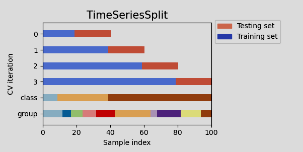

In [ ]:
# creating the stratified k fold instance
tscv = TimeSeriesSplit(n_splits=NUMBER_OF_FOLDS)

## 🤖 Treinamento com Validação Cruzada

Pipeline completo de otimização de hiperparâmetros e treinamento do modelo.

### 🎯 Otimização de Hiperparâmetros com Optuna

**Framework**: Optuna para otimização bayesiana
**Objetivo**: Minimizar WMAPE na validação cruzada
**Parâmetros Otimizados**:
- `n_estimators`: Número de árvores
- `max_depth`: Profundidade máxima das árvores  
- `learning_rate`: Taxa de aprendizado
- `subsample`: Taxa de amostragem
- `colsample_bytree`: Taxa de amostragem de features

**Vantagem**: Busca eficiente pelo espaço de hiperparâmetros.

In [ ]:
def defining_hyperparams(trial, hyperparam_ranges):
    v1 = trial.suggest_int('max_depth', hyperparam_ranges['max_depth'][0], hyperparam_ranges['max_depth'][1], log=hyperparam_ranges['max_depth'][2])
    v2 = trial.suggest_int('n_estimators', hyperparam_ranges['n_estimators'][0], hyperparam_ranges['n_estimators'][1], log=hyperparam_ranges['n_estimators'][2])
    v3 = trial.suggest_float('learning_rate', hyperparam_ranges['learning_rate'][0], hyperparam_ranges['learning_rate'][1], log=hyperparam_ranges['learning_rate'][2])
    v4 = trial.suggest_float('reg_alpha', hyperparam_ranges['reg_alpha'][0], hyperparam_ranges['reg_alpha'][1], log=hyperparam_ranges['reg_alpha'][2])
    v5 = trial.suggest_float('reg_lambda', hyperparam_ranges['reg_lambda'][0], hyperparam_ranges['reg_lambda'][1], log=hyperparam_ranges['reg_lambda'][2])
    v6 = trial.suggest_float('min_child_weight', hyperparam_ranges['min_child_weight'][0], hyperparam_ranges['min_child_weight'][1], log=hyperparam_ranges['min_child_weight'][2])
    v7 = trial.suggest_float('subsample', hyperparam_ranges['subsample'][0], hyperparam_ranges['subsample'][1], log=hyperparam_ranges['subsample'][2])
    v8 = trial.suggest_float('colsample_bytree', hyperparam_ranges['colsample_bytree'][0], hyperparam_ranges['colsample_bytree'][1], log=hyperparam_ranges['colsample_bytree'][2])
    return {'max_depth':v1, 'n_estimators':v2, 'learning_rate':v3, 'reg_alpha':v4,
            'reg_lambda':v5, 'min_child_weight':v6, 'subsample':v7, 'colsample_bytree':v8}

In [ ]:
# Configuring and execute the study
study = optuna.create_study(study_name='best_model', directions=[OPTUNA_PARAMS['DIRECTION'], OPTUNA_PARAMS['DIRECTION']])
study.set_metric_names(["score_validation", "score_overfitting"])

study.optimize(utils.create_objective_function(hyperparam_ranges            = MODEL_RANGE_PARAMS,
                                            tscv                            = tscv,
                                            x_data                          = [X_train,y_train],
                                            regressor_model                 = XGBRegressor,
                                            columns_to_use                  = [FEATURE_COLUMNS, LABEL_COLUMNS, NUMERIC_COLUMNS, CATEGORICAL_COLUMNS],
                                            eval_features                   = EVAL_FEATURES,
                                            preprocessing                   = PREPROCESSING,
                                            random_state                    = RANDOM_STATE,
                                            defining_hyperparams_function   = defining_hyperparams,
                                            multi_scores                    = True),
                                            n_trials                        = OPTUNA_PARAMS['TRIALS']
)

In [ ]:
# saving best params of otm optuna into variable
_, best_params = utils.get_best_params(study)
print(best_params)

## TRAINING WITH BEST PARAMS

In [ ]:
# dataframe with the predictions and expected values
df_results = pd.DataFrame()

# dataframe to hold important features of models
df_feature_importances = pd.DataFrame()

# dictionary to hold the cross validation results from each fold

## FITTING THE MODEL THE LAST TIME

### Re-creating the pre-processing pipeline

In [ ]:
pipe_preproc = utils.create_preprocessing_pipeline(preprocessing_configs=PREPROCESSING, numeric_columns=NUMERIC_COLUMNS, categorical_columns=CATEGORICAL_COLUMNS)

### Fitting the model  to the training data

In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessor', pipe_preproc), ('model', XGBRegressor(**best_params, random_state=RANDOM_STATE))
])

# training the model
pipeline.fit(X_train.loc[:, FEATURE_COLUMNS], y_train.loc[:, LABEL_COLUMNS].values.ravel())

### Evaluating model performance

In [ ]:
# creating a reference copy of the training and test data
X_train = df.loc[X_train.index].copy()
X_test = df.loc[X_test.index].copy()
train, test = X_train.loc[:, EVAL_FEATURES + [LABEL_COLUMNS]], X_test.loc[:, EVAL_FEATURES + [LABEL_COLUMNS]]

# getting the predictions for the training and test sets
train['predicted'] = pipeline.predict(X_train.loc[:, FEATURE_COLUMNS])
test['predicted'] = pipeline.predict(X_test.loc[:, FEATURE_COLUMNS])

# rounding train and test predictions
train['predicted_rounded'] = np.round(train['predicted'].values).astype(np.int32)
test['predicted_rounded'] = np.round(test['predicted'].values).astype(np.int32)

In [ ]:
# calculating the error for the training and test sets
error_train = utils.wmape_score(y_true = train[LABEL_COLUMNS].values, y_pred = train['predicted'].values)
error_test = utils.wmape_score(y_true = test[LABEL_COLUMNS].values, y_pred = test['predicted'].values)

error_train_rounded = utils.wmape_score(y_true = train[LABEL_COLUMNS].values, y_pred = train['predicted_rounded'].values)
error_test_rounded = utils.wmape_score(y_true = test[LABEL_COLUMNS].values, y_pred = test['predicted_rounded'].values)

print(f"WMAPE Train: {error_train:.3f}%")
print(f"WMAPE Test: {error_test:.3f}%")

print(f"WMAPE Train Rounded: {error_train_rounded:.3f}%")
print(f"WMAPE Test Rounded: {error_test_rounded:.3f}%")

## SAVING RESULTS

In [ ]:
output_directory = f"outputs/{dt.datetime.now().strftime(format= '%Y%m%d%H%M')}_XGBOOST/"
output_model_directory = output_directory + 'model'
output_data_directory = output_directory + 'data'
output_params_directory = output_directory + 'params'
output_optuna_directory = output_directory + 'study'

for directory in [output_model_directory, output_data_directory, output_params_directory, output_params_directory, output_optuna_directory]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [ ]:
# saving the json dictionary with the parameters
with open(f'{output_params_directory}/exepriment_params.json', 'w') as f:
    configs_all = {**configs, **best_params}
    json.dump(configs_all, f, indent=4)

# datasets
X_train.to_parquet(f'{output_data_directory}/training_set.parquet', index=False)
X_test.to_parquet(f'{output_data_directory}/test_set.parquet', index=False)

# pipeline
with open(f'{output_model_directory}/pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# saving study
with open(f'{output_optuna_directory}/best_metric_study.pkl', 'wb') as f:
    pickle.dump(study, f)